In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import operator

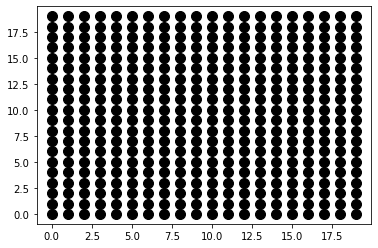

In [7]:
N=20
location={}
iteration=1
for i in range(N):
    for j in range(N):
        plt.scatter(i,j,s=100,c='k')
        location[iteration]=(i,j)
        iteration+=1

In [3]:
for n in [iteration-1]:
    Xdic={}
    for i in range(1,iteration):
        Xdic[i,'x']=location[i][0]
        Xdic[i,'y']=location[i][1]
        Xdic[i,'D']=np.random.uniform()
    
    AllTour={}
    for i in range(1,n+1):
        for j in range(1,n+1):
            if i!=j and sqrt((Xdic[i,'x']-Xdic[j,'x'])**2+(Xdic[i,'y']-Xdic[j,'y'])**2)<=1.1:
                AllTour[i,j]=Xdic[i,'D']*Xdic[j,'D']
            else:
                AllTour[i,j]=100
    allowed={}
    for i in range(1,n+1):
        for j in range(1,n+1):
            if i!=j and AllTour[i,j]<=1.1:
                allowed[i,j]=1

    model = AbstractModel()
    model.N =Param(mutable=True, default=n) 
    model.i = RangeSet(1,model.N)
    model.j = Set(initialize=model.i)
    model.U = Var(model.i,model.j, initialize=1, within=Binary)
    model.flow = Var(model.i,model.j,bounds=(0,1), within=NonNegativeReals)
    model.G = Var(bounds=(0,1), within=NonNegativeReals)
    
    def initvalTerminal(model,i):
        if random.uniform(0,1)<0.1:
            return 1
        else:
            return 0
    model.Terminal=Param(model.i, mutable=True, initialize=initvalTerminal) 
    def initval(model,i):
        return random.uniform(0,1)
    model.Xloc=Param(model.i, initialize=initval,mutable=True)
    model.Yloc=Param(model.i, initialize=initval, mutable=True)

    def Rule_D(model,i,j):
        return AllTour[i,j]    
    model.D=Param(model.i,model.j,  initialize=Rule_D, mutable=True)

    def rule_C1(model,i):
        if i==1:
            return model.G                         ==sum(model.flow[i,j]-model.flow[j,i] for j in model.j if (i,j) in allowed )
        else:
            return        -model.Terminal[i]/model.N==sum(model.flow[i,j]-model.flow[j,i] for j in model.j if (i,j) in allowed )
    model.C1   = Constraint(model.i,rule=rule_C1)

    def rule_C2(model,i,j):
        if (i,j) in allowed:
            return model.flow[i,j]<=1.2*model.U[i,j]
        else:
            return Constraint.Skip
    model.C2   = Constraint(model.i,model.j,rule=rule_C2)
    def rule_OF(model):
        return sum(model.U[r,c]*model.D[r,c] for (r,c) in allowed )
    model.obj1 = Objective(rule=rule_OF, sense=minimize)

    opt = SolverFactory('gurobi')
    model.N=n
    instance = model.create_instance()
    for i in instance.i:
        instance.Yloc[i]=Xdic[i,'y']
        instance.Xloc[i]=Xdic[i,'x']
        for j in instance.j:
            instance.D[i,j]=sqrt((Xdic[i,'x']-Xdic[j,'x'])**2+(Xdic[i,'y']-Xdic[j,'y'])**2)

    results = opt.solve(instance) # solves and updates instance
    print('OF= ',value(instance.obj1))
    print ("The solver returned a status of:"+str(results.solver.status))
    from pyomo.opt import SolverStatus, TerminationCondition
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
         print ("this is feasible and optimal")
    elif results.solver.termination_condition == TerminationCondition.infeasible:
         print ("do something about it? or exit?")
    else:
         print (str(results.solver))

OF=  28.0
The solver returned a status of:ok
this is feasible and optimal


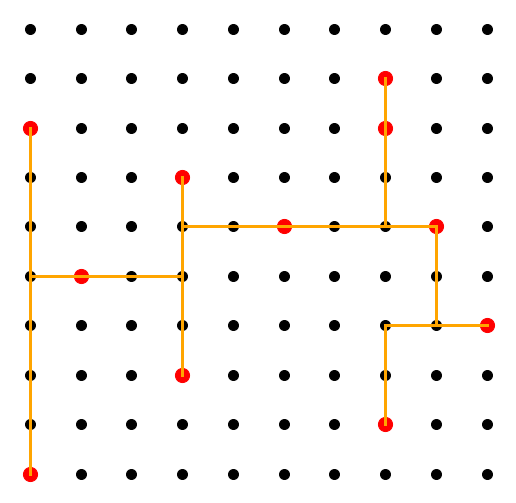

In [6]:
fig = plt.figure(figsize=(9,9))
for (i,j) in allowed:
    if value(instance.U[i,j])>0:
        plt.plot((Xdic[i,'x'],Xdic[j,'x']),(Xdic[i,'y'],Xdic[j,'y'])  , lw=3,c='orange', alpha=1)
for i in instance.i:
    plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i), s=100,c='k')
    if value(instance.Terminal[i]) >0 or i==1:
        plt.scatter(value(instance.Xloc[i]),value(instance.Yloc[i]),label=str(i), s=200,c='r')

plt.axis('off')
plt.savefig('TSP and MST for '+str(n)+' cities .png', format='png', bbox_inches='tight', dpi=200)



In [5]:
len(allowed)

360